In [1]:
import sys
sys.path.append('../')
import os
from dotenv import load_dotenv
import random
from cyto_ml.data.vectorstore import vector_store
from cyto_ml.data.intake import image_source
from cyto_ml.models.scivision import load_model, raw_model, prepare_image, SCIVISION_URL
from skimage import io
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
load_dotenv()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f54942677c0>>
Traceback (most recent call last):
  File "/home/jowals/miniconda3/envs/cyto_39/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/home/jowals/miniconda3/envs/cyto_39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

Grab the index of images - we should really be doing this with the intake catalogue, but the vector store is closer to hand


In [ ]:
store = vector_store('plankton')
store.count()
res = store.get()


INFO:root:Collection plankton already exists


To recap, we've got a index of plankton images with a set of vectors (the feature embeddings) which plausibly return related samples on a similarity search, and want to better understand why it works

In [ ]:
# test_image_url = random.choice(res['ids'])
test_image_url = f'{os.environ['ENDPOINT']}/untagged-images/19_10_Tank22_601.tif'

test_embed = store.get([test_image_url],include=['embeddings'])['embeddings']
results = store.query(
    query_embeddings=test_embed,
    n_results=9
)


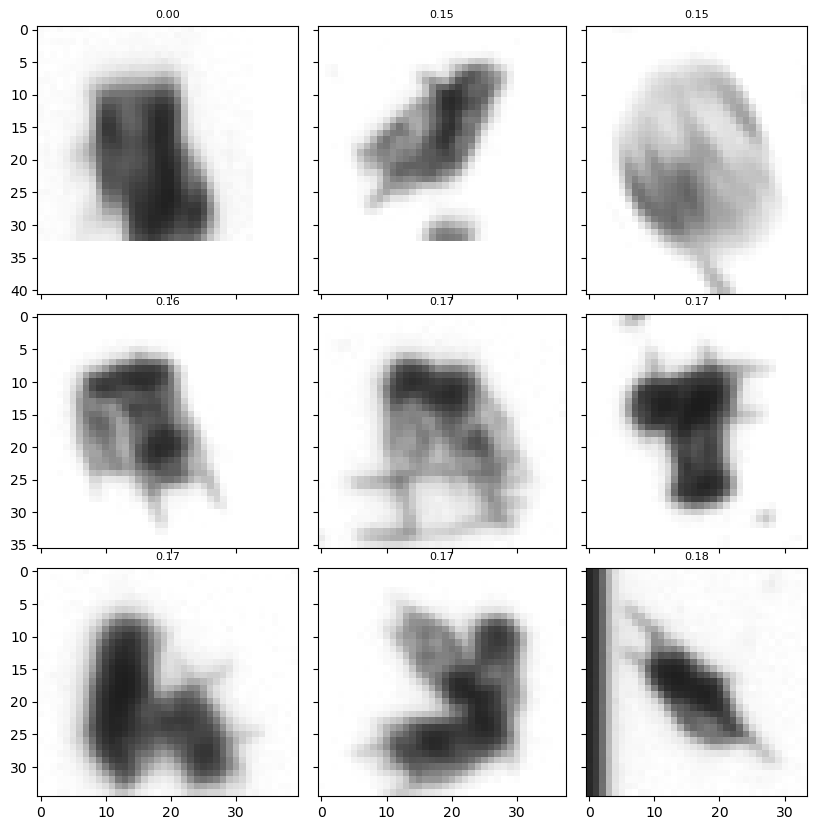

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for index, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(io.imread(results['ids'][0][index]))
    dist = results['distances'][0][index]
    ax.set_title(f'{dist:.2f}', fontsize=8)

A lot of the collection is detritus, we were really lucky to pick a distinct form at random last time.

`19_10_Tank22_601.tif` is a decent example of a complex but not very consistent one

Load the original `plankton-cefas` scivision model (trained on similar image data but at a different resoultion), we'll use it to make predictions and work backwards from them

In [ ]:
model = raw_model(load_model(SCIVISION_URL))

INFO:scivision.koala:Call='load_pretrained_model', module='scivision.io.reader', signature=(path: os.PathLike, branch: str = 'main', allow_install: bool = False, model_selection: str = 'default', load_multiple: bool = False, *args, **kwargs) -> scivision.io.wrapper.PretrainedModel, kwargs_given=''


We could run them all through and get a set of 3 labels

In [ ]:
predictions = []
image_urls = results['ids'][0]
for i in image_urls:
    predictions.append(model(prepare_image(image_source(i))))

/home/jowals/miniconda3/envs/cyto_39/lib/python3.9/site-packages/xarray/core/dataarray.py:1399: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(
/home/jowals/miniconda3/envs/cyto_39/lib/python3.9/site-packages/intake_xarray/image.py:474: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(ds2.dims),
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/jowals/miniconda3/envs/cyto_39/lib/python3.9/site-packages/xarray/core/dataarray.py:1399: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


[Captum torchvision walkthrough notebook](https://captum.ai/tutorials/TorchVision_Interpret) shows a grab-bag of approaches for interpreting a classification model, let's experiment with them

In [ ]:
import torch.nn.functional as F
import torchvision
import torch
from torchvision import models
from torchvision import transforms
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [ ]:
input = prepare_image(image_source(image_urls[0]))
transformed_img = input # for ease of re-use of the examples - which normalize the image first

I have seen work that shows this approach can be spurious (e.g. results appear interesting but are replicable with a default network) but can't remember the reference. Let's try all the approaches in the walkthrough, though

In [ ]:
output = F.softmax(predictions[0], dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
from matplotlib.colors import LinearSegmentedColormap

pred_label_idx.squeeze_()

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

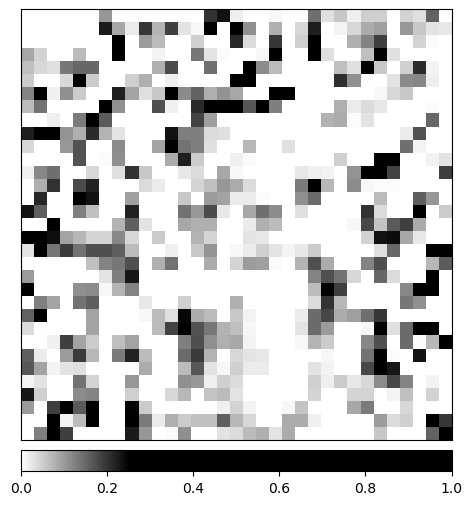

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

That honestly looks like garble to me, compare with the original image.
None of the rest do much better, left notes on both the probable causes and the next steps in the issue:
https://github.com/NERC-CEH/plankton_ml/issues/6

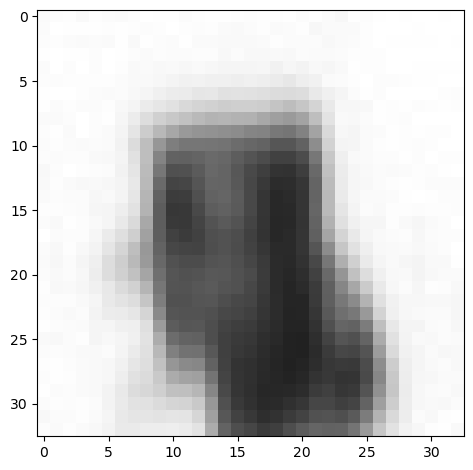

In [ ]:
from skimage.io import imshow
imshow(io.imread(test_image_url))

Have a look at the occlusion-based approach ("_We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes._"). Frankly it couldn't be less illuminating. Decreased the sliding window / stride option as our images are tiny. It might be more interesting if we can see a few of them with those values iterating.

This cell takes about 5 minutes to run, it iterates through the whole image set with different parameters for the occlusion method starting with a very fine grained area and working up to a larger one. It still looks really inclusive. I made the video linked in the issue from this output, like this

`ffmpeg -r 4 -pattern_type glob -i "*.png" -c:v libx264 -pix_fmt yuv420p -movflags +faststart output.mp4`

In [ ]:
occlusion = Occlusion(model)

# Just run this once, save the resulting image
params = [[2,2,2]]

# Uncomment and extend for the full "demoscene effect" visualisation
#params = [[2,2,2],
#          [2,2,3],
#          [2,3,3],
#          [3,3,3],
#          [3,3,4],
#          [3,4,4]]

def do_plot(s0,s2,s3,input,index):
    attributions_occ = occlusion.attribute(input,
                                        strides = (s0, s2, s2),
                                        target=pred_label_idx,
                                        sliding_window_shapes=(s0,s3,s3),
                                        baselines=0)
    try:
        plot, _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                            np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                            ["original_image", "heat_map"],
                                            ["all", "positive"],
                                            show_colorbar=False,
                                            use_pyplot=False,  
                                            outlier_perc=2)
        plot.savefig(f'test_{index}_{s0}_{s1}_{s2}_{s3}.png')
    except Exception as err:
        print

for index, i in enumerate(image_urls):
    image_s = prepare_image(image_source(i))
    for p in params:
        do_plot(*p,image_s,index)


"_Layer-Wise Relevance Propagation (LRP)... uses a backward propagation mechanism applied sequentially to all layers of the model, to see which neurons contributed to the output._"
... "_let's play around with changing the propagation rules for the various layers. This is a crucial step to get expressive heatmaps_" but the latter logic is really hardcoded to the VGG16 model in the example, so let's keep moving

/home/jowals/miniconda3/envs/cyto_39/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


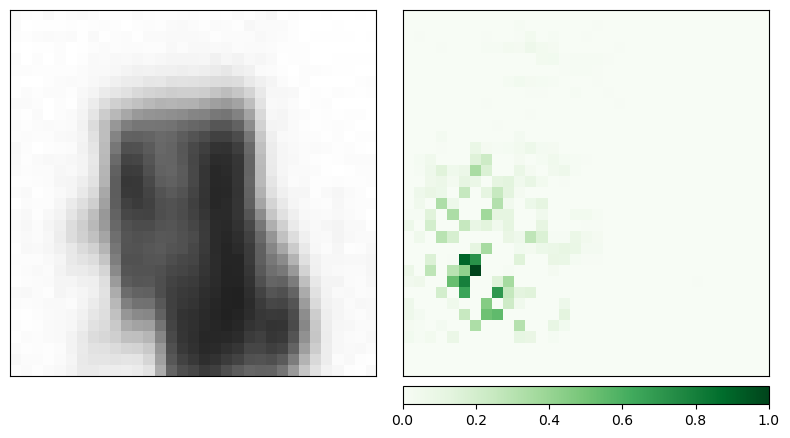

In [ ]:
model.eval()
lrp = LRP(model)

attributions_lrp = lrp.attribute(input, 
                                target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

GradientSHAP. `target` needs to be smaller than the number of classes

In [ ]:
gradient_shap = GradientShap(model)
input = transformed_img
# choosing baselines randomly - adjust this for our input size... 
# TODO if we come back here, use transformed_img.shape for the baseline shape
baselines = torch.randn(50, 3, 33, 33)
# Computes gradient shap for the input
# Attribution size matches input size: 3x3x32x32
attribution = gradient_shap.attribute(input, baselines,
                                             target=2)


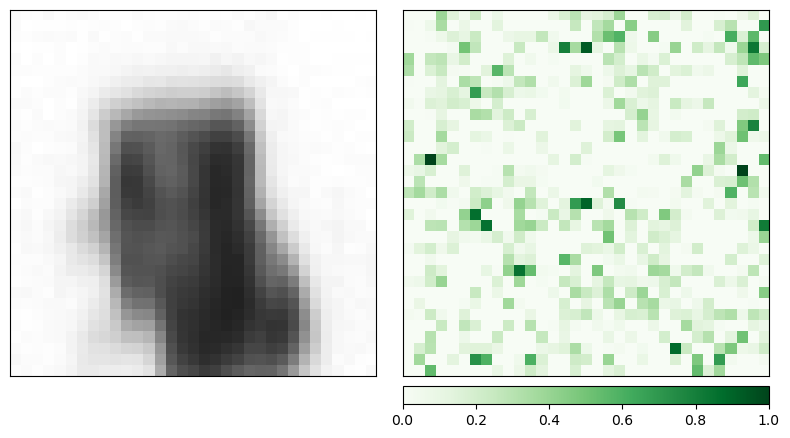

In [ ]:

_ = viz.visualize_image_attr_multiple(np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

... back to where we started with gradient attribution - this doesn't work as an interpretation.